In [ ]:
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split


images_path = '/content/drive/MyDrive/RETOECHO/images2K.npy'
heatmaps_path = '/content/drive/MyDrive/RETOECHO/EQUALheatmaps.npy'

images = np.load(images_path)
heatmaps = np.load(heatmaps_path)

# Split the data into training and testing sets


In [ ]:
images = images.astype('float32')
heatmaps = heatmaps.astype('float32')

train_images, valid_images, train_heatmaps, valid_heatmaps = train_test_split(
    images, heatmaps, test_size=0.2, random_state=42
)

print(f'Image min value: {train_images.min()}')
print(f'Image max value: {train_images.max()}')
print(f'heatmap min value: {heatmaps.min()}')
print(f'heatmap max value: {heatmaps.max()}')

Image min value: 0.0
Image max value: 1.0
heatmap min value: 0.0
heatmap max value: 1.0


# Reshape and Check the shape of the datasets


In [ ]:
train_heatmaps = np.transpose(train_heatmaps, (0, 2, 3, 1))
valid_heatmaps = np.transpose(valid_heatmaps, (0, 2, 3, 1))

print("Train images shape:", train_images.shape)
print("Train heatmaps shape:", train_heatmaps.shape)
print("valid images shape:", valid_images.shape)
print("valid heatmaps shape:", valid_heatmaps.shape)


Train images shape: (1600, 112, 112, 3)
Train heatmaps shape: (1600, 112, 112, 6)
valid images shape: (400, 112, 112, 3)
valid heatmaps shape: (400, 112, 112, 6)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# we define the metric dice_coefficient


In [ ]:
def dice_coefficient(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    return (2.0 * intersection + 1e-15) / (union + 1e-15)

# Modified U net model to generate 6 heatmaps per image

In [ ]:
def unet_model_for_heatmaps(input_size=(112, 112, 3), num_classes=6):
    inputs = keras.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = unet_model_for_heatmaps()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[dice_coefficient])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

# We train the model with 30 epochs

In [ ]:
history = model.fit(
    train_images,
    train_heatmaps,
    validation_data=(valid_images, valid_heatmaps),
    epochs=30,
    batch_size=32
)


# We visualize the results for a random image

1/1 [==============================] - 1s 956ms/step


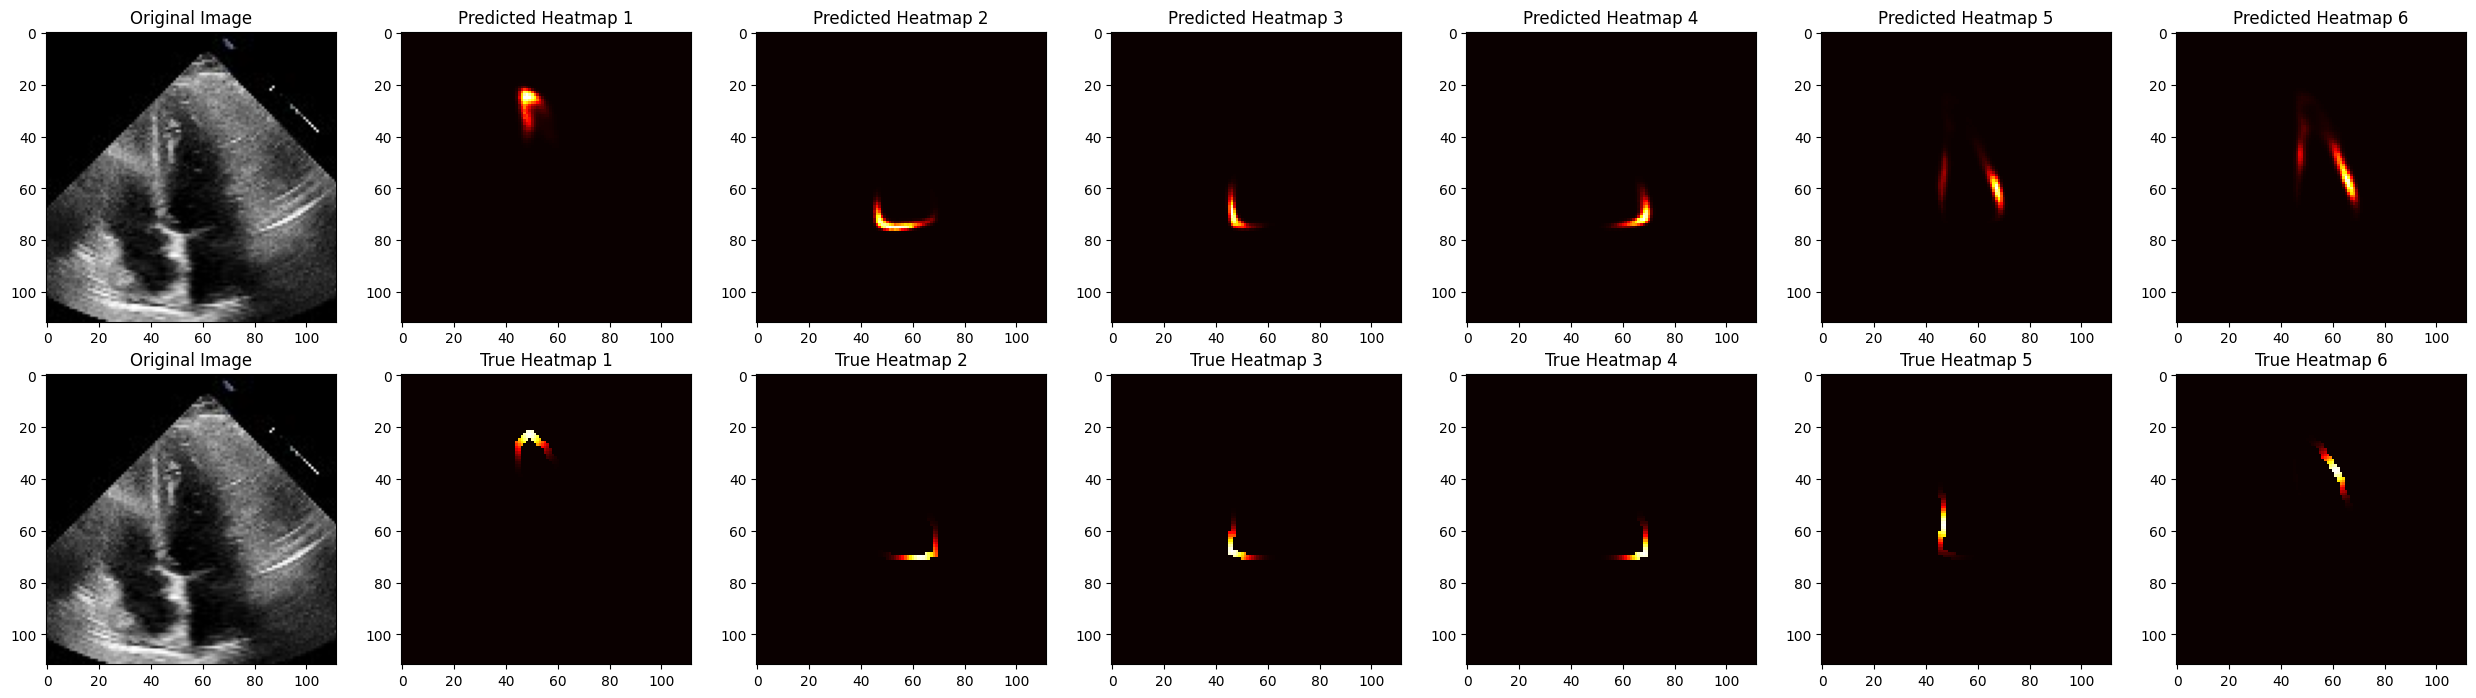

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

index = np.random.randint(0, len(valid_images))

image = valid_images[index]
true_heatmap = valid_heatmaps[index]

predicted_heatmap = model.predict(np.expand_dims(image, axis=0))[0]

fig, axs = plt.subplots(2, 7, figsize=(25, 7))

axs[0, 0].imshow(image)
axs[0, 0].title.set_text('Original Image')
axs[1, 0].imshow(image)
axs[1, 0].title.set_text('Original Image')

for i in range(6):
    axs[0, i + 1].imshow(predicted_heatmap[..., i], cmap='hot', interpolation='nearest')
    axs[0, i + 1].title.set_text(f'Predicted Heatmap {i+1}')

for i in range(6):
    axs[1, i + 1].imshow(true_heatmap[..., i], cmap='hot', interpolation='nearest')
    axs[1, i + 1].title.set_text(f'True Heatmap {i+1}')

plt.tight_layout()
plt.show()


# for better visualization we overaly the heatmaps with the image

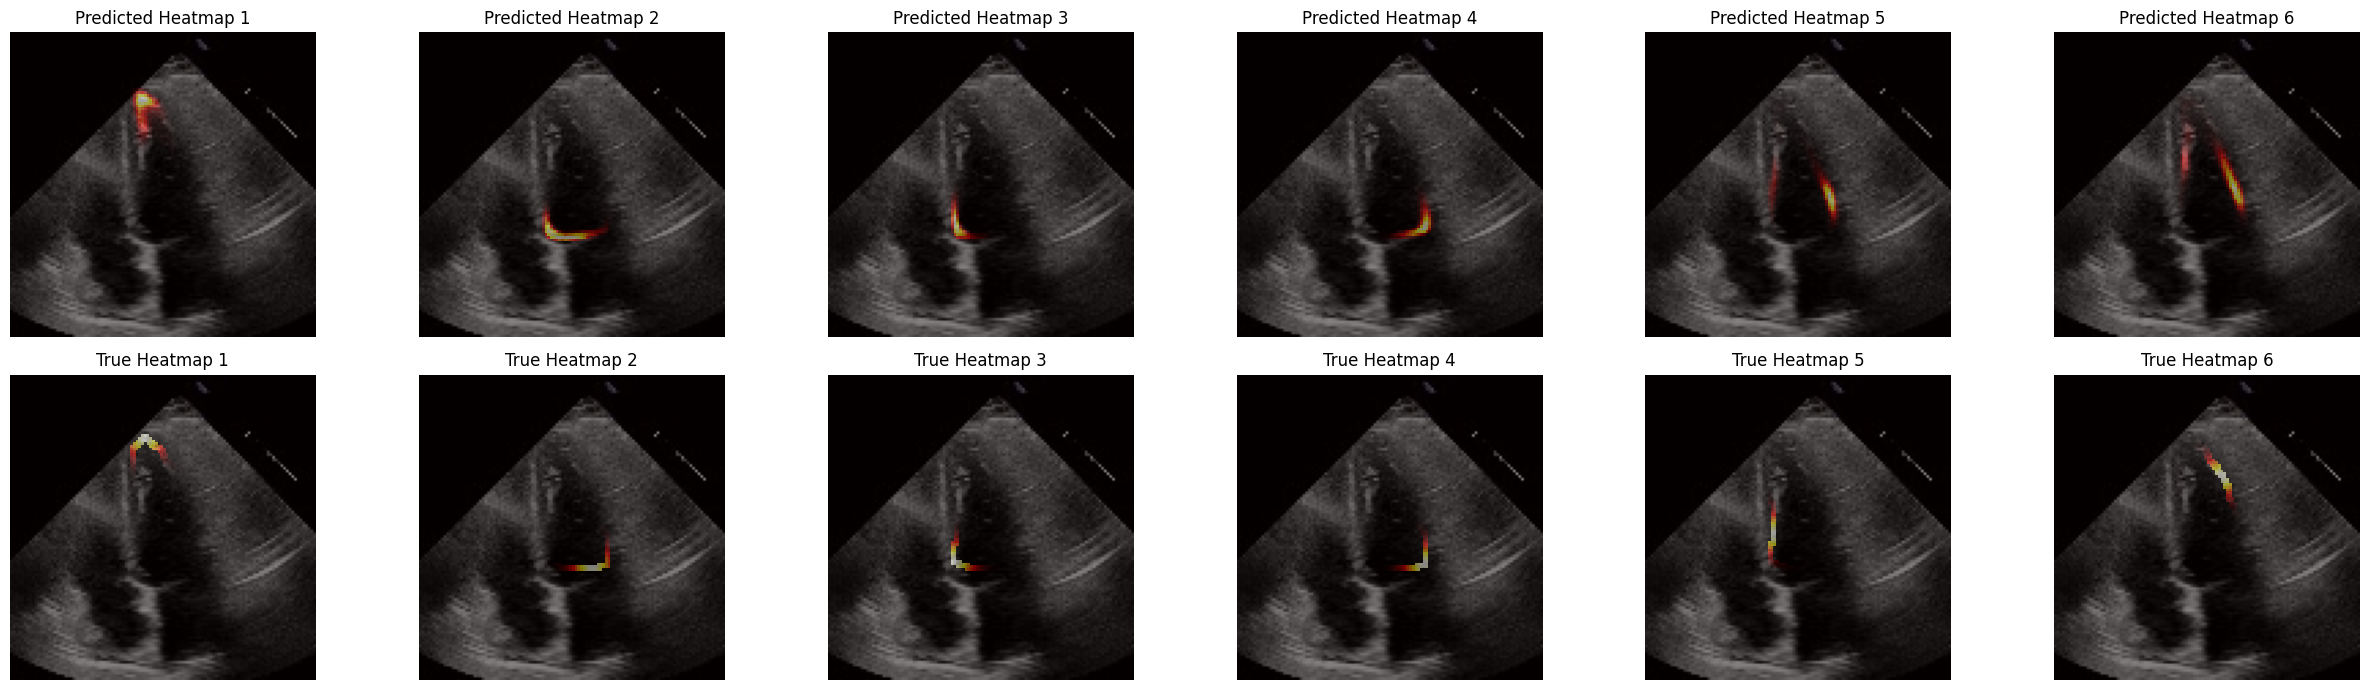

In [ ]:
fig, axs = plt.subplots(2, 6, figsize=(25, 7))

for i in range(6):
    axs[0, i].imshow(image, cmap='gray')
    axs[0, i].imshow(predicted_heatmap[..., i], cmap='hot', alpha=0.5, interpolation='nearest')
    axs[0, i].title.set_text(f'Predicted Heatmap {i+1}')

for i in range(6):
    axs[1, i].imshow(image, cmap='gray')
    axs[1, i].imshow(true_heatmap[..., i], cmap='hot', alpha=0.5, interpolation='nearest')
    axs[1, i].title.set_text(f'True Heatmap {i+1}')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()


# We extract the landmarks from the heatmaps, we sort them by position, and we create the masks


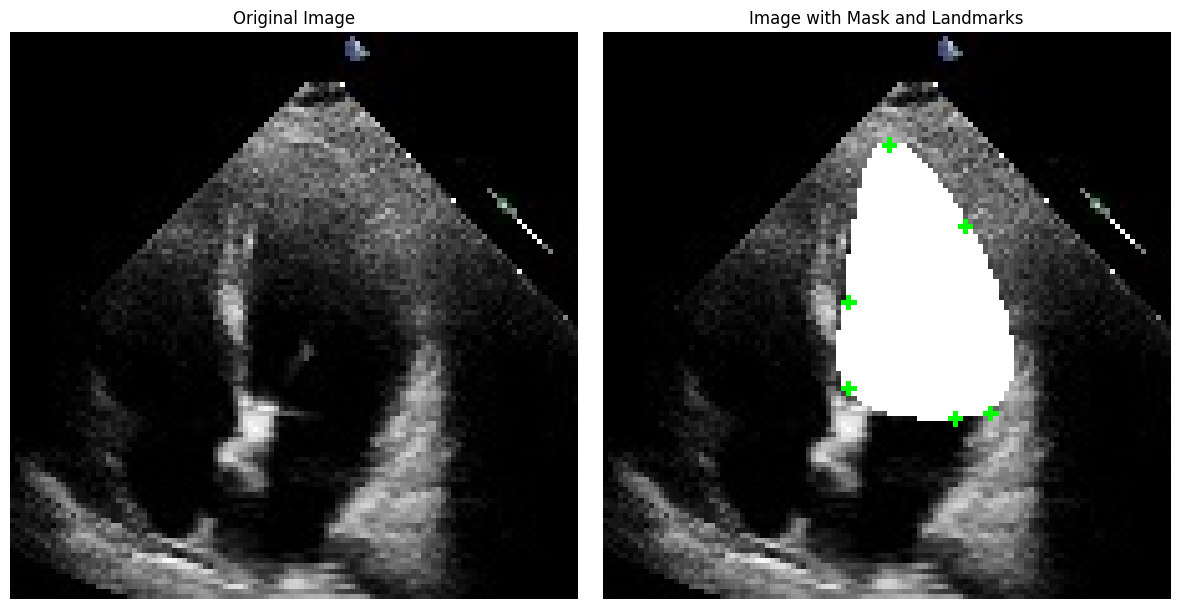

In [ ]:
from scipy.interpolate import splprep, splev
import numpy as np
import matplotlib.pyplot as plt
import cv2

def extract_landmarks(heatmap):
    return np.unravel_index(np.argmax(heatmap), heatmap.shape)

def calculate_centroid(points):
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    centroid_x = sum(x) / len(points)
    centroid_y = sum(y) / len(points)
    return centroid_x, centroid_y

def sort_points_clockwise(points):
    centroid_x, centroid_y = calculate_centroid(points)
    return sorted(points, key=lambda p: (np.arctan2(p[1] - centroid_y, p[0] - centroid_x), p[0]))

def refined_sort(points):
    sorted_points_angle = sort_points_clockwise(points)

    refined_points = [sorted_points_angle[0]]
    for i in range(1, len(sorted_points_angle)-1):
        current_point = sorted_points_angle[i]
        distances = [(np.linalg.norm(np.array(current_point) - np.array(sorted_points_angle[j])), j)
                     for j in range(i-1, min(i+2, len(sorted_points_angle)))]
        distances.sort(key=lambda x: x[0])
        refined_points.append(sorted_points_angle[distances[0][1]])

    refined_points.append(sorted_points_angle[-1])
    return refined_points

def draw_mask_from_landmarks(image, landmarks, smooth_factor=.1):
    if len(landmarks) < 2:
        return np.zeros_like(image, dtype=np.uint8)

    sorted_landmarks = refined_sort(landmarks)

    sorted_landmarks = np.array(sorted_landmarks).T

    try:
        tck, u = splprep([sorted_landmarks[1], sorted_landmarks[0]], s=smooth_factor, per=True)
    except Exception as e:
        print(f"Error in spline fitting: {e}")
        return np.zeros_like(image, dtype=np.uint8)

    new_points = splev(np.linspace(0, 1, 100), tck)
    points = np.array([new_points[0], new_points[1]]).T.astype(np.int32)

    mask = np.zeros_like(image, dtype=np.uint8)

    cv2.fillPoly(mask, [points], 255)

    return mask

def overlay_mask_on_image(image, mask, landmarks):
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    if len(image.shape) == 3 and image.shape[2] == 3:
        mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    else:
        mask_color = mask

    mask_color = mask_color.astype(image.dtype)

    overlayed_image = cv2.addWeighted(image, 1, mask_color, 0.6, 0)

    for landmark in landmarks:
        cv2.circle(overlayed_image, (landmark[1], landmark[0]), 1, (0, 255, 0), -1)

    return overlayed_image

index = np.random.randint(0, len(valid_images))
image = valid_images[index]
heatmaps = model.predict(np.expand_dims(image, axis=0))[0]

landmarks = [extract_landmarks(heatmaps[..., i]) for i in range(heatmaps.shape[-1])]

sorted_landmarks = refined_sort(landmarks)
mask = draw_mask_from_landmarks(image, sorted_landmarks)

overlayed_image = overlay_mask_on_image(image, mask, landmarks)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(overlayed_image)
axs[1].set_title('Image with Mask and Landmarks')
axs[1].axis('off')

plt.tight_layout()
plt.show()


# We use probability lines and the key heatmaps to create the masks (still under development)

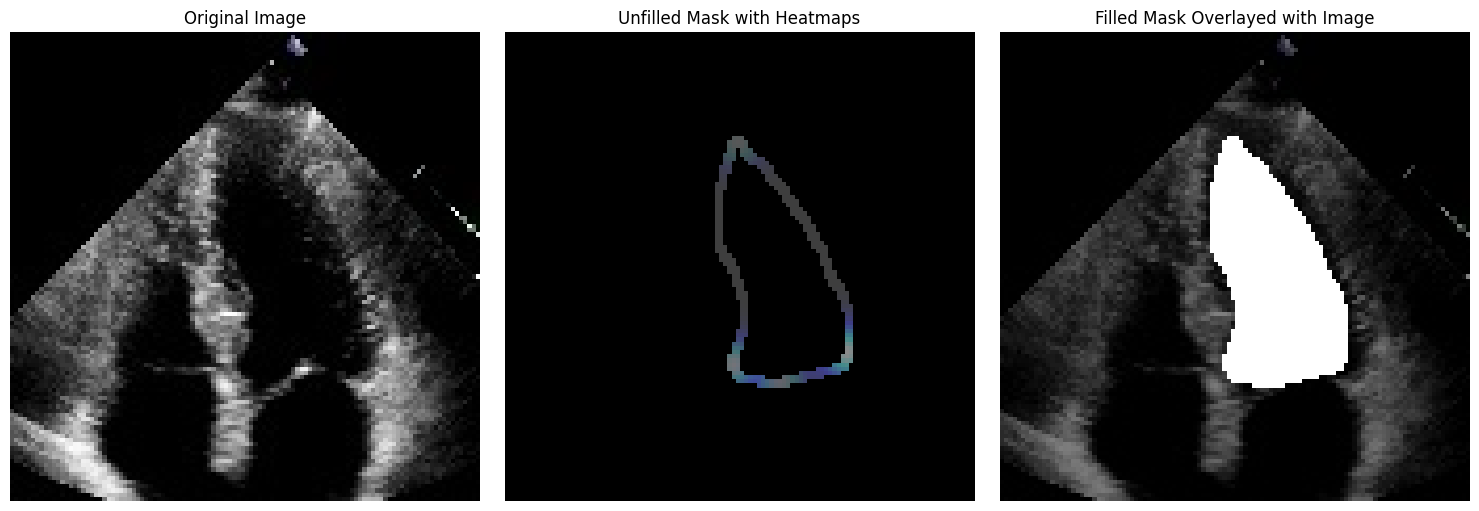

In [ ]:
import cv2
import numpy as np

def find_inner_point(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    largest_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(largest_contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        return (cx, cy)
    else:
        return None

def fill_contours(mask):
    filled_mask = mask.copy()
    inner_point = find_inner_point(mask)
    if inner_point is not None:
        h, w = mask.shape
        flood_fill_mask = np.zeros((h + 2, w + 2), np.uint8)
        cv2.floodFill(filled_mask, flood_fill_mask, inner_point, 255)
    return filled_mask

def create_mask_from_heatmaps(heatmaps, percentile=95):
    mask = np.zeros_like(heatmaps[..., 0], dtype=np.uint8)
    priority_indices = [0, 1, 2, 3]

    for i in priority_indices:
        thresholded = heatmaps[..., i] > np.percentile(heatmaps[..., i], percentile)
        mask[thresholded] = 255

    for i in range(4, heatmaps.shape[-1]):
        thresholded = heatmaps[..., i] > np.percentile(heatmaps[..., i], percentile)
        mask[thresholded] = 255

    return mask, fill_contours(mask)


def overlay_heatmap_on_mask(mask, heatmap, alpha=0.3):
    norm_heatmap = cv2.normalize(heatmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    colored_heatmap = cv2.applyColorMap(norm_heatmap, cv2.COLORMAP_HOT)

    if len(mask.shape) == 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    overlayed_mask = cv2.addWeighted(mask, 1 - alpha, colored_heatmap, alpha, 0)
    return overlayed_mask

def overlay_mask_on_image(image, mask, alpha=0.5):
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    if len(image.shape) == 3 and image.shape[2] == 3:
        mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    else:
        mask_color = mask

    mask_color = mask_color.astype(image.dtype)

    overlayed_image = cv2.addWeighted(image, 1-alpha, mask_color, alpha, 0)

    return overlayed_image

index = np.random.randint(0, len(valid_images))
image = valid_images[index]
heatmaps = valid_heatmaps[index]

unfilled_mask, filled_mask = create_mask_from_heatmaps(heatmaps)

for i in range(4):
    unfilled_mask = overlay_heatmap_on_mask(unfilled_mask, heatmaps[..., i])

overlayed_image = overlay_mask_on_image(image, filled_mask)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(unfilled_mask)
axs[1].set_title('Unfilled Mask with Heatmaps')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('Filled Mask Overlayed with Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

